# Проверка статистических гипотез в крупком интернет - магазине.

# Содержание
1. [Загрузка и предобработка данных](#start)
2. [Приоритизация гипотез](#priority)
3. [Анализ A/B-теста](#A/B)<br>
    3.1. [График кумулятивной выручки](#cumulative)<br>
    3.2. [График кумулятивного среднего чека](#average)<br>
    3.3. [График относительного изменения кумулятивного среднего чека](#average_changes)<br>
    3.4. [График кумулятивного среднего количества заказов по группам](#cumulative_revenue)<br>
    3.5. [График относительного изменения кумулятивного среднего количества заказов группы B к группе A](#cumulative_changes)<br>
    3.6. [Точечный график количества заказов по пользователям](#qty_orders)<br>
    3.7. [Граница заказов для определения аномальных пользователей](#border_abnormal)<br>
    3.8. [Точечный график стоимостей заказов](#scatter_plot)<br>
    3.9. [Граница для определения аномальных заказов (по выручке)](#border_revenue)<br>
    3.10. [Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным](#row_qty)<br>
    3.11. [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#row_order)<br>
    3.12. [Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным](#clear_order)<br>
    3.13. [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#clear_order_mean)<br>
    3.14. [Решение по результатам теста](#conclusions)<br>

<b> Описание проекта </b> <br>
Контекст :<br>
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки. Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.


<b>Описание данных</b> <br>
Hypothesis — краткое описание гипотезы;<br>
Reach — охват пользователей по 10-балльной шкале;<br>
Impact — влияние на пользователей по 10-балльной шкале;<br>
Confidence — уверенность в гипотезе по 10-балльной шкале;<br>
Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.<br>


transactionId — идентификатор заказа;<br>
visitorId — идентификатор пользователя, совершившего заказ;<br>
date — дата, когда был совершён заказ;<br>
revenue — выручка заказа;<br>
group — группа A/B-теста, в которую попал заказ.<br>

date — дата;<br>
group — группа A/B-теста;<br>
visitors — количество пользователей в указанную дату в указанной группе A/B-теста<br>


<a id="start"></a>
### Загрузка и предобработка данных

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import os
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats

In [2]:
# Чтенение файлов
df = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors = pd.read_csv('/datasets/visitors.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
df.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1


In [5]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [6]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders['date'] = pd.to_datetime(orders['date'])

In [8]:
orders.duplicated().sum()

0

In [9]:
print(f'Кол-во уникальных пользователей: {orders.visitorId.nunique()}')

Кол-во уникальных пользователей: 1031


In [10]:
orders.groupby('visitorId')['group'].nunique().sort_values(ascending = False).head()

visitorId
2654030115    2
3891541246    2
3941795274    2
1404934699    2
351125977     2
Name: group, dtype: int64

In [11]:
orders_2 = orders.groupby('visitorId')['group'].nunique().reset_index().query('group > 1')['visitorId']
orders_2.nunique()

58

58 пользователей, сделавших заказ, которые попали в обе группы. Хоть они и составляют 5,6% от общего числа пользователей, считаю корректым исключить их из анализа, чтобы получить более достоверные выводы.

In [12]:
orders = orders.query('visitorId not in @orders_2')
print(f'Кол-во уникальных пользователей после удаления пользователей из обеих групп: {orders.visitorId.nunique()}')

Кол-во уникальных пользователей после удаления пользователей из обеих групп: 973


In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [14]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [15]:
visitors['date'] = pd.to_datetime(visitors['date'])

In [16]:
visitors.duplicated().sum()

0

В процессе предобработки был изменен тип столбца 'date' на datetime в таблицах orders и visitors. Данные целостны, без дубликатов, готовы к анализу. Также были удалены пользователи, попавшие в обе группы, думаю, что правильно удаль пользователей, попавших в обе группы, чтобы не искажать результаты анализа. 

<a id="priority"></a>
### Приоритизация гипотез 

In [21]:
df['Ice'] = df['Impact'] * df['Confidence'] / df['Efforts']
df['Rice'] = df['Reach'] * df['Impact'] * df['Confidence'] / df['Efforts']
df[['Ice', 'Hypothesis']].sort_values(by='Ice', ascending=False)

,Ice,Hypothesis
8,16.200000,"Запустить акцию, дающую скидку на товар в день..."
0,13.333333,"Добавить два новых канала привлечения трафика,..."
7,11.200000,Добавить форму подписки на все основные страни...
6,8.000000,Показать на главной странице баннеры с актуаль...
2,7.000000,Добавить блоки рекомендаций товаров на сайт ин...
1,2.000000,"Запустить собственную службу доставки, что сок..."
5,1.333333,"Добавить страницу отзывов клиентов о магазине,..."
3,1.125000,"Изменить структура категорий, что увеличит кон..."
4,1.000000,"Изменить цвет фона главной страницы, чтобы уве..."


In [22]:
df[['Rice', 'Hypothesis']].sort_values(by='Rice', ascending=False)

,Rice,Hypothesis
7,112.0,Добавить форму подписки на все основные страни...
2,56.0,Добавить блоки рекомендаций товаров на сайт ин...
0,40.0,"Добавить два новых канала привлечения трафика,..."
6,40.0,Показать на главной странице баннеры с актуаль...
8,16.2,"Запустить акцию, дающую скидку на товар в день..."
3,9.0,"Изменить структура категорий, что увеличит кон..."
1,4.0,"Запустить собственную службу доставки, что сок..."
5,4.0,"Добавить страницу отзывов клиентов о магазине,..."
4,3.0,"Изменить цвет фона главной страницы, чтобы уве..."


При применении Rice меняется выбор приоритетной гипотезы. Изменение связано с тем, что в фреймворке Rice используется дополнительный параметр Reach, который учитывает скольких пользователей затронет изменение, которое хотят внести. При применении фреймворка Ice приоритетна гипотеза 8, а при Rice 7. 

<a id="A/B"></a>
### Анализ A/B-теста

<a id="cumulative"></a>
#### График кумулятивной выручки по группам

In [23]:
datesGroups = orders[['date','group']].drop_duplicates()
ordersAggregated = datesGroups\
       .apply(lambda x: orders[np.logical_and(orders['date'] <=x['date'], orders['group'] == x['group'])] \
       .agg({'date':'max', 'group':'max','transactionId':'nunique','revenue':'sum'}), axis=1) \
       .sort_values(by=['date','group'])

In [24]:
visitorsAggregated = datesGroups \
        .apply(lambda x: visitors[np.logical_and(visitors['date'] <=x['date'], visitors['group'] == x['group'])] \
        .agg({'date':'max', 'group':'max','visitors':'sum'}), axis=1) \
        .sort_values(by=['date','group'])       

In [25]:
cumulativeData = ordersAggregated.merge(visitorsAggregated, on = ['date','group'])
cumulativeData = cumulativeData.rename(columns={'transactionId': 'orders'})

In [26]:
cumulativeData.head()

,date,group,orders,revenue,visitors
0,2019-08-01,A,23,142779,719
1,2019-08-01,B,17,59758,713
2,2019-08-02,A,42,234381,1338
3,2019-08-02,B,40,221801,1294
4,2019-08-03,A,66,346854,1845


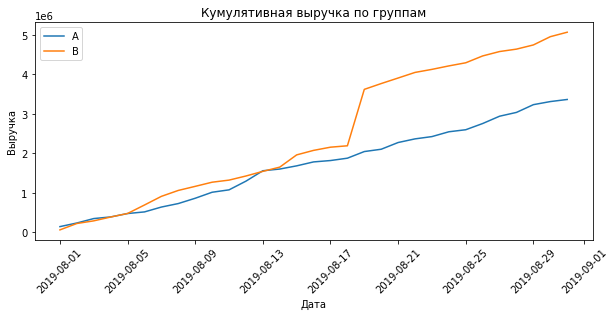

In [27]:
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'],cumulativeRevenueB['revenue'], label='B')
plt.legend() 
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation=45)
plt.show()

В начале месяца выручка в группе B растет немного быстрее. 19 августа происходит резкий скачок, и далее выручка в группе B остается выше.

In [28]:
cumulativeRevenueB.query('"2019-08-17" <=date <="2019-08-21"')

,date,revenue,orders
33,2019-08-17,2155542,320
35,2019-08-18,2190865,327
37,2019-08-19,3620785,348
39,2019-08-20,3768059,368
41,2019-08-21,3908406,380


Количество заказов 19.08 не выбивается из количкества заказов в другие дни.

In [29]:
orders.query('date =="2019-08-19"').sort_values(by='revenue', ascending=False).head()

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A
461,2683113224,154576532,2019-08-19,26550,B


Видим, что 19.08 был сделан один дорогой заказ, который вызвал рост на графике. И который можно считать выбросом.

<a id="average"></a>
#### График кумулятивного среднего чека

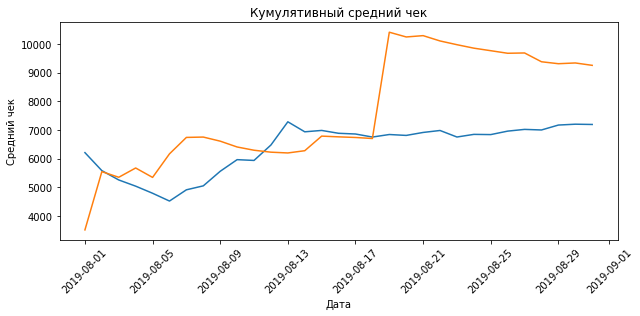

In [30]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation=45)
plt.show()

В начале месяца средний чек группы В был преимущественной больше. Также заметно влиятние дорогого заказа 19.08, после которого средний чек группы В стал постоянно больше, но заметно некоторое понижение в 20-ых числах месяца, тогда как средний чек группы А немного растет.

<a id="average_changes"></a>
#### График относительного изменения кумулятивного среднего чека

In [31]:
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, on = 'date', suffixes=['_A', '_B'])
mergedCumulativeRevenue.head()

,date,revenue_A,orders_A,revenue_B,orders_B
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


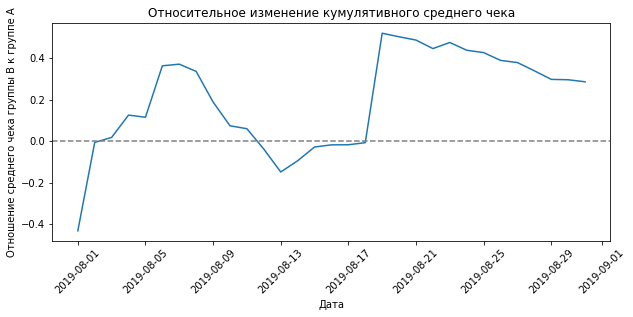

In [32]:
plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenue_B']/mergedCumulativeRevenue['orders_B']) /
         (mergedCumulativeRevenue['revenue_A']/mergedCumulativeRevenue['orders_A'])-1) 
plt.axhline(y=0, color='grey', linestyle='--') 
plt.title('Относительное изменение кумулятивного среднего чека')
plt.xlabel('Дата')
plt.ylabel('Отношение среднего чека группы В к группе А')
plt.xticks(rotation=45)
plt.show()

Из графика видно, что средний чек группы А был больше в период с 12.08 - 14.08, а в остальное время средний чек группы В больше, хотя после всплеска 19.08, когда был сделан заказ на значительную сумму, средний чек группы В постепенно снижается.

<a id="cumulative_revenue"></a>
#### График кумулятивного среднего количества заказов по группам

In [33]:
#cumulativeData['orders_avg'] = cumulativeData['orders'] / cumulativeData['visitors']

In [34]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
cumulativeDataA.head()

,date,group,orders,revenue,visitors
0,2019-08-01,A,23,142779,719
2,2019-08-02,A,42,234381,1338
4,2019-08-03,A,66,346854,1845
6,2019-08-04,A,77,388030,2562
8,2019-08-05,A,99,474413,3318


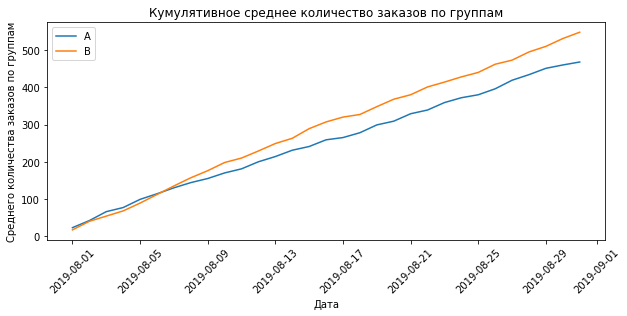

In [35]:
plt.figure(figsize=(10,4))
plt.plot(cumulativeDataA['date'], cumulativeDataA['orders'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['orders'], label='B')
plt.legend()
plt.title('Кумулятивное среднее количество заказов по группам')
plt.xlabel('Дата')
plt.ylabel('Среднего количества заказов по группам')
plt.xticks(rotation=45)
plt.show()

Глядя на график можно сделать вывод, что количество заказов в группе В больше, чем в группе А и со временем разрыв увеличивается.

<a id="cumulative_changes"></a>
#### График относительного изменения кумулятивного среднего количества заказов группы B к группе A

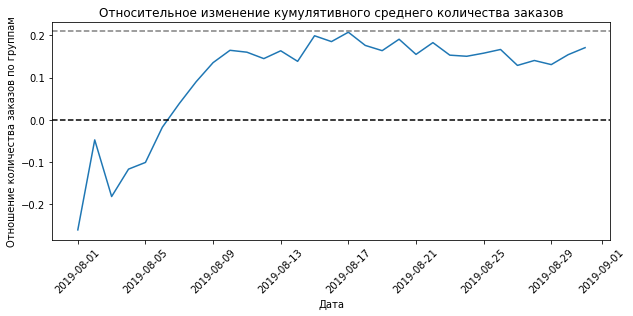

In [36]:
mergedCumulativeOrders =cumulativeDataA[['date', 'orders']] \
         .merge(cumulativeDataB[['date', 'orders']], on='date', suffixes=['_A', '_B'])

plt.figure(figsize=(10,4))
plt.plot(mergedCumulativeOrders['date'], \
         mergedCumulativeOrders['orders_B']/mergedCumulativeOrders['orders_A']-1)
plt.title('Относительное изменение кумулятивного среднего количества заказов')
plt.xlabel('Дата')
plt.ylabel('Отношение количества заказов по группам')
plt.xticks(rotation=45)
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.21, color='gray', linestyle='--')
plt.show()

По графику можно сделать вывод, что в начале тестирования количество заказов группы А было больше, кроме 2.08. После 6.08 количество заказов группы В стало расти и в остальной период было стабильно больше.

<a id="qty_orders"></a>
#### Точечный график количества заказов по пользователям

In [37]:
ordersByUsers = orders.groupby('visitorId', as_index=False).agg({'transactionId':'nunique'})
ordersByUsers.columns = ['userId', 'orders']

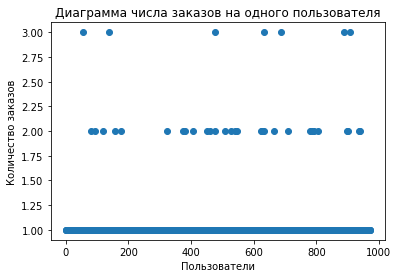

In [38]:
x_value = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_value, ordersByUsers['orders'])
plt.title('Диаграмма числа заказов на одного пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Количество заказов')
plt.show()

Большинство покупателей сделали 1 заказ, тех, кто сделал 2 заказа тоже определенная часть, но больше 3 заказов мало кто сделал. 

<a id="border_abnormal"></a>
#### Граница заказов для определения аномальных пользователей

In [39]:
print('95-й и 99-й перцентили количества заказов на пользователя равны', np.percentile(ordersByUsers['orders'],[95,99]))

95-й и 99-й перцентили количества заказов на пользователя равны [1. 2.]


In [40]:
print('97-й перцентиль количества заказов на пользователя равен', np.percentile(ordersByUsers['orders'],[97]))

97-й перцентиль количества заказов на пользователя равен [2.]


Не более 5% оформили больше 1 заказов, и не более 1% оформили 2 заказа. Выберу 2 заказа на одного пользователя за верхнюю границу числа заказов, т.к. и не более 3% оформили больше 2 заказов, значит большее количество заказов можно считать аномальными.

<a id="scatter_plot"></a>
#### Точечный график стоимостей заказов

In [41]:
revenueByUsers = orders.groupby('visitorId', as_index=False).agg({'revenue':'sum'})

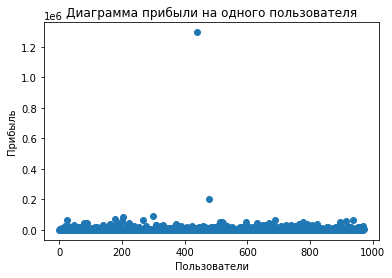

In [42]:
x_value_rev = pd.Series(range(0, len(revenueByUsers)))
plt.scatter(x_value_rev, revenueByUsers['revenue'])
plt.title('Диаграмма прибыли на одного пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Прибыль')
plt.show()

Чтобы лучше увидеть распределение прибыли, исключу аномальный заказ.

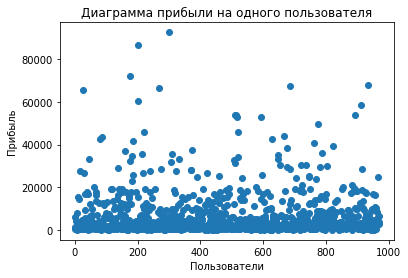

In [43]:
norm_revenue = revenueByUsers.query('revenue < 200000')

x_value_rev = pd.Series(range(0, len(norm_revenue)))
plt.scatter(x_value_rev, norm_revenue['revenue'])
plt.title('Диаграмма прибыли на одного пользователя')
plt.xlabel('Пользователи')
plt.ylabel('Прибыль')
plt.show()

По графику прибыли видно, что большинство заказов находятся до 100 000.

<a id="border_revenue"></a>
#### Граница для определения аномальных заказов (по выручке)

In [44]:
print('95-й и 99-й перцентили стоимости заказов на пользователя равны',np.percentile(orders['revenue'], [95,99]))

95-й и 99-й перцентили стоимости заказов на пользователя равны [26785. 53904.]


Не более 1% оформили заказы дороже 53904. Установим данное значение в качестве аномального.

<a id="row_qty"></a>
#### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным

In [45]:
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <=x['date']] \
   .agg({'date':'max', 'visitorsPerDateA':'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


visitorsBDaily = visitors[visitors['group']=='B'][['date','visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']
visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <=x['date']] \
   .agg({'date':'max', 'visitorsPerDateB':'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']] \
   .groupby('date', as_index=False) \
   .agg({'transactionId' : pd.Series.nunique, 'revenue':'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date']<=x['date']] \
    .agg({'date':'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1)
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']] \
    .groupby('date', as_index=False) \
    .agg({'transactionId' : pd.Series.nunique, 'revenue':'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date']<=x['date']] \
    .agg({'date':'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1)
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (ordersADaily.merge(ordersBDaily, on='date', how='left')
    .merge(ordersACummulative, on='date', how='left')
    .merge(ordersBCummulative, on='date', how='left')
    .merge(visitorsADaily, on='date', how='left')
    .merge(visitorsBDaily, on='date', how='left')
    .merge(visitorsACummulative, on='date', how='left')
    .merge(visitorsBCummulative, on='date', how='left'))

In [46]:
print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

Нулевая гипотеза - статистически значимых различий в среднем количестве заказов между группами нет.<br>
Альтернативная гипотеза - статистически значимые различия есть.

In [47]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False) \
   .agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False) \
   .agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() \
                                                        - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'], pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() \
                                                        - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print('alpha =', 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))
print("Относительный показатель = {0:.3f}".format(sampleB.mean() /sampleA.mean() -1))

alpha = 0.05
p-value = 0.011
Относительный показатель = 0.160


P-value = 0.011, что меньше alph. Значит можно отвегрнуть нулевую гипотезу о том, что нет статистически значимых различий в среднем количестве заказов между группами. По «сырым» данным есть различия в количестве заказов групп A и B. Относительный выигрыш группы B равен 16.0% .

<a id="row_order"></a>
#### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Нулевая гипотеза - статистически значимых различий в средних чеках между группами нет. <br>
Альтернативная гипотеза - статистически значимые различия есть.

In [48]:
print('alpha =', 0.05)
print("p-value = {0:.3f}".format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], \
                                          orders[orders['group']=='B']['revenue'])[1]))
print("Относительный показатель = {0:.3f}".format(orders[orders['group']=='B']['revenue']\
                                                  .mean() /orders[orders['group']=='A']['revenue'].mean() -1))

alpha = 0.05
p-value = 0.829
Относительный показатель = 0.287


P-value больше alpha, значит нет причин отвергать нулевую гипотезу, т.е. по сырым данным в средних чеках нет различий, а наблюдаемое превышение среднего чека группы В на 28,7% не является значимым, получено случайно.

<a id="clear_order"></a>
#### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным

Узнаем, сколько всего аномальных пользователей. Из предудыщих расчетов возьму количество аномальных заказов больше 2, сумма заказа больше 53904.

In [49]:
a =int(np.percentile(ordersByUsers['orders'],[99]))
b= int(np.percentile(orders['revenue'], [99]))

In [50]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders']>a]['userId'],
                                 ordersByUsersA[ordersByUsersB['orders']>a]['userId']], axis=0)
usersWithExpensiveOrders = orders[orders['revenue']>b]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates()

print('Всего аномальных пользователей:', abnormalUsers.shape[0])

Всего аномальных пользователей: 16


Посмотрим, как их действия повлияло на результаты теста.

In [51]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], \
    pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()-len(ordersByUsersA['orders'])),  name='orders')],  axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], \
    pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum()-len(ordersByUsersB['orders'])),  name='orders')],  axis=0)

print('alpha =', 0.05)
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный показатель = {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

alpha = 0.05
p-value = 0.005
Относительный показатель = 0.208


P-value меньше alpha = 0.05, значит нулевую гипотезу отвергаем, что значит, что есть есть различия в конверсии группы В и А. Относительный выйгрыш равен 20,8%.

<a id="clear_order_mean"></a>
#### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [53]:
print('alpha =', 0.05)
print('p-value ={0:.3f}'.format(stats.mannwhitneyu(orders[np.logical_and(orders['group']=='A', \
                                             np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'], 
                                         orders[np.logical_and(orders['group']=='B', \
                                            np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'])[1]))


print('Относительный показатель = {0:.3f}'.format(orders[np.logical_and(orders['group']=='B', \
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean() / 
                       orders[np.logical_and(orders['group']=='A', \
                              np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean()-1))


alpha = 0.05
p-value =0.839
Относительный показатель = -0.029


P-value равен 83,9%, что значительно выше alpha =0.05, значит нет причин отвергать нулевую гипотезу и считать,что в средних чеках есть различия тоже нет. Средний чек группы B оказался немного ниже среднего чека группы A на 0.029%

<a id="conclusions"></a>
#### Решение по результатам теста

По сырым и очищенным данным есть различия в количестве заказов групп А и В. Относительный выигрыш по очищенным данным группы В равен 20,8%.


Отсутствуют отличия в средних чеках группы А и В как по сырым данным, так и по очищенным. Разница в 28,7% в средних чеках по сырым данным была вызвана аномальным заказом в группе В.

По результатам тестирования можно сделать вывод о приостановке тестирования и в качестве победиля считать победу группы B : группа B лучше группы A по количеству заказов, хотя по среднему чеку группы примерно равны.